## **Classe TensProv**  
La classe **TensProv** est conçue pour construire un **tenseur de provenance binaire épars**, idéal pour suivre l'origine des données tout au long de diverses transformations, telles que :  
- La réduction Verticale
- La réduction Horizentale
- L'augmentation  
- La jointure  
- La concaténation  

Cette classe fournit des **méthodes performantes et flexibles** pour capturer efficacement la provenance des données.  
Chaque opération proposée est accompagnée de **deux méthodes distinctes alternative et direct**, offrant une adaptation optimale aux différents cas d’usage.  

---

### **Types d'opérations prises en charge**  

1. **Réduction horizontale (`filter_data`)** 
   - Filtrage des lignes basé sur un sous-ensemble spécifique.  

2. **Réduction verticale (`drop_columns`)**  
   - Suppression de colonnes jugées non nécessaires.  

3. **Augmentation horizontale (`oversample_data`)**  
   - Ajout de nouvelles lignes pour enrichir le jeu de données.  

4. **Augmentation verticale (`one_hot_encode`)**  
   - Ajout de nouvelles colonnes, permettant d’intégrer des dimensions supplémentaires.  

5. **Jointure (`join_data`)**  
   - Combinaison de deux DataFrames via une ou plusieurs clés communes.  

6. **Concaténation (`append_data`)**  
   - Fusion de deux DataFrames en ajoutant leurs lignes de manière séquentielle.  

---

### **Méthodes auxiliaires**  

1. **`evaluate_performance`**  
   - Retourne le temps d'exécution de chaque opération effectuée.  

2. **`get_tensor`**  
   - Retourne le tenseur binaire épars sous forme dense.  


In [312]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
import time

class TensProv:
    """
    Initialise la classe avec un tenseur vide et une structure de performances.
    """
    def __init__(self):
        self.tensor = None
        self.performance = {}
    
    # ------------------------------------------------------------------
    # 1) Filtrage (horizontal reduction) : deux méthodes (direct / alt)
    # ------------------------------------------------------------------
    def filter_data(self, data_in, condition_func, method='direct'):
        """
        Applique un filtrage horizontal sur data_in.
        Construit ensuite le tenseur de provenance.

        Args:
            data_in (pd.DataFrame): le DataFrame d'entrée
            condition_func (function): fonction prenant une ligne et retournant True/False
            method (str): 'direct' ou 'alt', deux variantes d'implémentation
        
        Returns:
            (data_out, tensor) : DataFrame filtré + la matrice de provenance (csr_matrix)
        """
        start_time = time.time()

        #Génération du data_out
        bool_mask = data_in.apply(condition_func, axis=1)
        data_out = data_in[bool_mask].copy()

        #Construction du tenseur
        if method == 'direct':
            self._filter_data_direct(data_in, data_out)
        elif method == 'alt':
            self._filter_data_alt(data_in, data_out)
        else:
            raise ValueError(f"Unknown filter method: {method}")

        self.performance[f"filter_data({method})"] = time.time() - start_time
        return data_out, self.tensor

    def _filter_data_direct(self, data_in, data_out):
        """
        Méthode 'direct' : on mappe les index de data_out sur les index de data_in.
        """
        rows = data_out.index
        col_idx_map = {idx: i for i, idx in enumerate(data_in.index)}
        row_idx_map = {idx: i for i, idx in enumerate(data_out.index)}

        row_list, col_list, data_list = [], [], []
        for out_idx in data_out.index:
            row_list.append(row_idx_map[out_idx])
            col_list.append(col_idx_map[out_idx])
            data_list.append(1)

        shape = (len(data_out), len(data_in))
        self.tensor = csr_matrix((data_list, (row_list, col_list)), shape=shape)

    def _filter_data_alt(self, data_in, data_out):
        """
        Méthode 'alt' : autre approche, on utilise get_indexer_for.
        """
        row_list = np.arange(len(data_out))
        # On récupère la position de chaque index de data_out dans data_in
        col_array = data_in.index.get_indexer_for(data_out.index)
        data_array = np.ones(len(data_out))

        shape = (len(data_out), len(data_in))
        self.tensor = csr_matrix((data_array, (row_list, col_array)), shape=shape)

    # ------------------------------------------------------------------
    # 2) Réduction verticale (drop columns) : deux méthodes (direct / alt)
    # ------------------------------------------------------------------
    def drop_columns(self, data_in, columns_to_drop, method='direct'):
        """
        Applique une réduction verticale (suppression de colonnes).
        Construit le tenseur de provenance.

        Args:
            data_in (pd.DataFrame): le DataFrame d'entrée
            columns_to_drop (list): liste des colonnes à supprimer
            method (str): 'direct' ou 'alt'
        
        Returns:
            (data_out, tensor): DataFrame résultat + provenance
        """
        start_time = time.time()

        #Génération du data_out
        data_out = data_in.drop(columns=columns_to_drop).copy()

        #Construction du tenseur
        if method == 'direct':
            self._drop_columns_direct(data_in, data_out)
        elif method == 'alt':
            self._drop_columns_alt(data_in, data_out)
        else:
            raise ValueError(f"Unknown drop_columns method: {method}")

        self.performance[f"drop_columns({method})"] = time.time() - start_time
        return data_out, self.tensor

    def _drop_columns_direct(self, data_in, data_out):
        """
        Méthode 'direct' : pour chaque colonne conservée, on met un 1.
        """
        out_cols = data_out.columns
        in_cols = data_in.columns

        row_map = {col: i for i, col in enumerate(out_cols)}
        col_map = {col: i for i, col in enumerate(in_cols)}

        row_list, col_list, data_list = [], [], []
        for col in out_cols:
            if col in col_map:
                row_list.append(row_map[col])
                col_list.append(col_map[col])
                data_list.append(1)

        shape = (len(data_out.columns), len(data_in.columns))
        self.tensor = csr_matrix((data_list, (row_list, col_list)), shape=shape)

    def _drop_columns_alt(self, data_in, data_out):
        """
         Méthode alt : Cette méthode identifie les colonnes qui ont été conservées 
         et attribue une valeur de 1 pour elles.

        """

        in_cols = list(data_in.columns)
        out_cols = list(data_out.columns)

        row_list, col_list, data_list = [], [], []
        row_map = {col: i for i, col in enumerate(out_cols)}
        col_map = {col: i for i, col in enumerate(in_cols)}

        for col in out_cols:
            row_list.append(row_map[col])
            col_list.append(col_map[col])
            data_list.append(1)

        shape = (len(out_cols), len(in_cols))
        self.tensor = csr_matrix((data_list, (row_list, col_list)), shape=shape)

    # ------------------------------------------------------------------
    # 3) Oversampling (horizontal augmentation) : deux méthodes (direct / alt)
    # ------------------------------------------------------------------
    def oversample_data(self, data_in, multiplier=2, method='direct'):
        """
        Duplique les lignes de data_in (horizontal augmentation).
        Construit le tenseur de provenance.

        Args:
            data_in (pd.DataFrame)
            multiplier (int)
            method (str): 'direct' ou 'alt'
        
        Returns:
            (data_out, tensor)
        """
        start_time = time.time()

        #Génération du data_out
        data_out_list = []
        for _ in range(multiplier):
            data_out_list.append(data_in.copy())
        data_out = pd.concat(data_out_list, ignore_index=True)

        #Construction du tenseur
        if method == 'direct':
            self._oversample_direct(data_in, data_out, multiplier)
        elif method == 'alt':
            self._oversample_alt(data_in, data_out, multiplier)
        else:
            raise ValueError(f"Unknown oversample method: {method}")

        self.performance[f"oversample_data({method})"] = time.time() - start_time
        return data_out, self.tensor

    def _oversample_direct(self, data_in, data_out, multiplier):
        """
        Méthode 'direct' : on considère que la i-ème ligne de data_out 
        provient de data_in[i % len(data_in)].
        """
        shape = (len(data_out), len(data_in))
        rows, cols, data_vals = [], [], []

        for out_i in range(len(data_out)):
            in_i = out_i % len(data_in)
            rows.append(out_i)
            cols.append(in_i)
            data_vals.append(1)

        self.tensor = csr_matrix((data_vals, (rows, cols)), shape=shape)

    def _oversample_alt(self, data_in, data_out, multiplier):
        """
        Méthode 'alt' : itère sur chaque duplication et sur chaque ligne de l’entrée 
        pour construire la matrice de provenance de manière plus “étape par étape”
        """
        shape = (len(data_out), len(data_in))
        rows, cols, data_vals = [], [], []

        num_in = len(data_in)
        # Pour chaque duplication k
        for k in range(multiplier):
            # pour chaque ligne i de data_in
            for i in range(num_in):
                out_i = k * num_in + i
                rows.append(out_i)
                cols.append(i)
                data_vals.append(1)

        self.tensor = csr_matrix((data_vals, (rows, cols)), shape=shape)

    # ------------------------------------------------------------------
    # 4) One-Hot Encoding (vertical augmentation) : deux méthodes (direct / alt)
    # ------------------------------------------------------------------
    def one_hot_encode(self, data_in, column, method='direct'):
        
        start_time = time.time()

        #Génération du data_out
        dummies = pd.get_dummies(data_in[column], prefix=column, dtype=int)
        data_out = pd.concat([data_in.drop(columns=[column]), dummies], axis=1)

        #Construction du tenseur
        if method == 'direct':
            self._one_hot_direct(data_in, data_out, column)
        elif method == 'alt':
            self._one_hot_alt(data_in, data_out, column)
        else:
            raise ValueError(f"Unknown one_hot_encode method: {method}")

        self.performance[f"one_hot_encode({method})"] = time.time() - start_time
        return data_out, self.tensor

    def _one_hot_direct(self, data_in, data_out, column):
        """
        Méthode 'direct' : boucle sur les lignes, puis pour chaque valeur, 
        place un “1” dans la colonne correspondante.
        """
        row_count = len(data_in)
        col_count_out = len(data_out.columns)

        rows, cols, data_vals = [], [], []

        for i in range(row_count):
            # Les colonnes d'origine (sauf la supprimée)
            for c in data_in.columns:
                if c != column:
                    out_col_index = data_out.columns.get_loc(c)
                    rows.append(i)
                    cols.append(out_col_index)
                    data_vals.append(1)
            # La colonne one-hot correspondant à la valeur
            new_col_name = f"{column}_{data_in.iloc[i][column]}"
            if new_col_name in data_out.columns:
                out_col_index = data_out.columns.get_loc(new_col_name)
                rows.append(i)
                cols.append(out_col_index)
                data_vals.append(1)

        shape = (row_count, col_count_out)
        self.tensor = csr_matrix((data_vals, (rows, cols)), shape=shape)

    def _one_hot_alt(self, data_in, data_out, column):
        """
        Méthode 'alt' : même principe mais sépare plus clairement la partie “colonnes inchangées” 
        et la partie “colonnes one-hot” dans la construction du tenseur.
        """
        row_count = len(data_in)
        col_count_out = len(data_out.columns)

        row_list, col_list, data_list = [], [], []

        # Mêmes principes, juste une autre méthode
        for i, row in data_in.iterrows():
            # colonnes inchangées
            for c in data_in.columns:
                if c != column:
                    out_col_index = data_out.columns.get_loc(c)
                    row_list.append(i)
                    col_list.append(out_col_index)
                    data_list.append(1)

            # colonnes one-hot
            val = row[column]
            colname = f"{column}_{val}"
            if colname in data_out.columns:
                out_col_index = data_out.columns.get_loc(colname)
                row_list.append(i)
                col_list.append(out_col_index)
                data_list.append(1)

        shape = (row_count, col_count_out)
        self.tensor = csr_matrix((data_list, (row_list, col_list)), shape=shape)

    # ------------------------------------------------------------------
    # 5) Jointure : deux méthodes (direct / alt) 
    #    (vous pouvez renommer alt en 'hash' si vous voulez)
    # ------------------------------------------------------------------
    def join_data(self, left_df, right_df, on, how='inner', method='direct'):
        """
        Joint deux DataFrames sur la colonne 'on'.
        Construit le tenseur de provenance.

        Args:
            left_df (pd.DataFrame)
            right_df (pd.DataFrame)
            on (str)
            how (str)
            method (str): 'direct' ou 'alt'
        
        Returns:
            (data_out, tensor)
        """
        start_time = time.time()
        data_out = pd.merge(left_df, right_df, on=on, how=how)

        #Construction du tenseur
        if method == 'direct':
            self._join_data_direct(left_df, right_df, data_out, on)
        elif method == 'alt':
            self._join_data_alt(left_df, right_df, data_out, on)
        else:
            raise ValueError(f"Unknown join_data method: {method}")

        self.performance[f"join_data({method})"] = time.time() - start_time
        return data_out, self.tensor

    def _join_data_direct(self, left_df, right_df, data_out, on):
        """
        Méthode 'direct' : pour chaque ligne du data_out, 
        on retrouve la/les ligne(s) correspondante(s) dans left_df, right_df.
        """
        total_in_rows = len(left_df) + len(right_df)
        shape = (len(data_out), total_in_rows)
        rows, cols, data_vals = [], [], []

        left_map = {idx: i for i, idx in enumerate(left_df.index)}
        right_map = {idx: i + len(left_df) for i, idx in enumerate(right_df.index)}

        for out_i, row in data_out.iterrows():
            key_val = row[on]
            left_matches = left_df.index[left_df[on] == key_val]
            right_matches = right_df.index[right_df[on] == key_val]

            for lm in left_matches:
                rows.append(out_i)
                cols.append(left_map[lm])
                data_vals.append(1)
            for rm in right_matches:
                rows.append(out_i)
                cols.append(right_map[rm])
                data_vals.append(1)

        self.tensor = csr_matrix((data_vals, (rows, cols)), shape=shape)

    def _join_data_alt(self, left_df, right_df, data_out, on):
        """
        Méthode 'alt' :  ajoute un hash sur la colonne
        de jointure dans les deux DataFrames et compare ces hash
        """
        import hashlib

        total_in_rows = len(left_df) + len(right_df)
        shape = (len(data_out), total_in_rows)
        rows, cols, data_vals = [], [], []

        # Ajouter une colonne de hash
        left_df["_hash_key"] = left_df[on].apply(lambda x: hashlib.md5(str(x).encode()).hexdigest())
        right_df["_hash_key"] = right_df[on].apply(lambda x: hashlib.md5(str(x).encode()).hexdigest())
        data_out["_hash_key"] = data_out[on].apply(lambda x: hashlib.md5(str(x).encode()).hexdigest())

        left_map = {idx: i for i, idx in enumerate(left_df.index)}
        right_map = {idx: i + len(left_df) for i, idx in enumerate(right_df.index)}

        for out_i, row in data_out.iterrows():
            out_hash = row["_hash_key"]
            left_matches = left_df.index[left_df["_hash_key"] == out_hash]
            right_matches = right_df.index[right_df["_hash_key"] == out_hash]

            for lm in left_matches:
                rows.append(out_i)
                cols.append(left_map[lm])
                data_vals.append(1)
            for rm in right_matches:
                rows.append(out_i)
                cols.append(right_map[rm])
                data_vals.append(1)

        # Nettoyage
        del left_df["_hash_key"]
        del right_df["_hash_key"]
        del data_out["_hash_key"]

        self.tensor = csr_matrix((data_vals, (rows, cols)), shape=shape)

    # ------------------------------------------------------------------
    # 6) Append : deux méthodes (direct / alt) 
    # ------------------------------------------------------------------
    def append_data(self, df1, df2, method='direct'):
        """
        Concatène verticalement df1 et df2.
        Construit le tenseur de provenance.

        Args:
            df1, df2 (pd.DataFrame)
            method (str): 'direct' ou 'alt'
        
        Returns:
            (data_out, tensor)
        """
        start_time = time.time()

        #Génération du data_out
        data_out = pd.concat([df1, df2]).reset_index(drop=True)

        #Construction du tenseur
        if method == 'direct':
            self._append_direct(df1, df2, data_out)
        elif method == 'alt':
            self._append_alt(df1, df2, data_out)
        else:
            raise ValueError(f"Unknown append_data method: {method}")

        self.performance[f"append_data({method})"] = time.time() - start_time
        return data_out, self.tensor

    def _append_direct(self, df1, df2, data_out):
        """
        Méthode 'direct': parcourt la sortie et identifie
        si la ligne appartient à df1 ou df2 en se basant sur l’index.
        """
        total_in_rows = len(df1) + len(df2)
        shape = (len(data_out), total_in_rows)
        rows, cols, data_vals = [], [], []

        df1_map = {idx: i for i, idx in enumerate(df1.index)}
        df2_map = {idx: i + len(df1) for i, idx in enumerate(df2.index)}

        for out_i in range(len(data_out)):
            if out_i < len(df1):
                original_idx = df1.index[out_i]
                rows.append(out_i)
                cols.append(df1_map[original_idx])
                data_vals.append(1)
            else:
                out_i_in_df2 = out_i - len(df1)
                original_idx = df2.index[out_i_in_df2]
                rows.append(out_i)
                cols.append(df2_map[original_idx])
                data_vals.append(1)

        self.tensor = csr_matrix((data_vals, (rows, cols)), shape=shape)

    def _append_alt(self, df1, df2, data_out):
        """
        Méthode 'alt': construit la correspondance en itérant sur 
        les indexes de df1 puis de df2 de façon plus séquentielle.

        """
        total_in_rows = len(df1) + len(df2)
        shape = (len(data_out), total_in_rows)
        row_list, col_list, data_list = [], [], []

        # On peut itèrer sur df1 + df2 directement
        curr_out = 0
        
        for idx in df1.index:
            row_list.append(curr_out)
            col_list.append(df1.index.get_loc(idx))
            data_list.append(1)
            curr_out += 1
        
        for idx in df2.index:
            row_list.append(curr_out)
            col_list.append(len(df1) + df2.index.get_loc(idx))
            data_list.append(1)
            curr_out += 1

        self.tensor = csr_matrix((data_list, (row_list, col_list)), shape=shape)
    def transform_data(self, data_in, column, method='direct'):
        import time
        start_time = time.time()
        data_out = data_in.copy()
        if method == 'direct':
            self._transform_data_direct(data_in, data_out, column)
        elif method == 'alt':
            self._transform_data_alt(data_in, data_out, column)
        else:
            raise ValueError(f"Unknown transform_data method: {method}")
        """
    Construction du tenseur de provenance
    Comme le schéma et le nombre de lignes ne changent pas,
    chaque ligne out_i provient directement de la même ligne in_i.
    => On crée une matrice diagonale.
    """

        num_rows = len(data_in)
        shape = (num_rows, num_rows)
        rows = np.arange(num_rows)
        cols = np.arange(num_rows)
        data_vals = np.ones(num_rows) 
        self.tensor = csr_matrix((data_vals, (rows, cols)), shape=shape)

        self.performance[f"transform_data({method})"] = time.time() - start_time
        return data_out, self.tensor

    def _transform_data_direct(self, data_in, data_out, column):
        """
        Méthode 'direct':
        Remplace les NaN  par la moyenne de 'column' dans data_in.
        """
        mean_val = data_in[column].mean() 
        data_out[column] = data_out[column].fillna(mean_val)

    def _transform_data_alt(self, data_in, data_out, column):
        """
        Méthode 'alt':
        Remplace les NaN  par la médiane de 'column' dans data_in.
        (Ou un autre critère, pour illustrer une alternative).
        """
        median_val = data_in[column].median()
        data_out[column] = data_out[column].fillna(median_val)



    # ------------------------------------------------------------------
    # Méthodes utilitaires
    # ------------------------------------------------------------------
    def evaluate_performance(self):
        """Retourne les performances des opérations effectuées."""
        return self.performance

    def get_tensor_dense(self):
        """Retourne le tenseur binaire épars sous forme dense (numpy array)."""
        if self.tensor is not None:
            return self.tensor.toarray()
        else:
            return None


# Explication et contexte du code

Maintenant nous allons tester et comparer différentes méthodes pour effectuer des opérations sur des DataFrames.
Nous allons générer deux DataFrames (`df` et `df2`) avec des colonnes telles que `ID`, `city`, `val`, et `cuisine`. 


Ensuite chaque opération est réalisée via deux approches : **Méthode directe** et **Méthode alternative** et les performances de chaque méthode sont calculées et comparées.



In [313]:
import psutil
import os
from memory_profiler import memory_usage

# Fonction pour obtenir l'utilisation de la mémoire
def suivre_utilisation_memoire(func, *args, **kwargs):
    utilisation_memoire = memory_usage((func, args, kwargs))
    return max(utilisation_memoire)  # en Mo

# Suivi de l'utilisation du CPU
def suivre_utilisation_cpu(func, *args, **kwargs):
    processus = psutil.Process(os.getpid())
    cpu_debut = processus.cpu_percent(interval=None)
    func(*args, **kwargs)  # Exécute la fonction
    cpu_fin = processus.cpu_percent(interval=None)
    return cpu_fin - cpu_debut


# **Géneration test de données**

Nous allons commencer par générer un DataFrame de test afin d'expérimenter les méthodes de transformation des données lorsqu'il y a des valeurs manquantes (NaN).

In [314]:
df_test = pd.DataFrame({
        'Name': ['Alice', 'Bob', 'Charlie', 'David', 'Eva', 
                 'Frank', 'Grace', 'Heidi', 'Ivan', 'Judy'],
        'Age': [25, np.nan, 30, 35, np.nan, 45, 38, np.nan, 50, 29],
        'Salary': [50000, 60000, np.nan, 80000, 70000, 90000, 62000, 58000, 91000, np.nan]
    })
# Instanciation
tens = TensProv()

In [315]:
df_test

,Name,Age,Salary
0,Alice,25.0,50000.0
1,Bob,NaN,60000.0
2,Charlie,30.0,NaN
3,David,35.0,80000.0
4,Eva,NaN,70000.0
5,Frank,45.0,90000.0
6,Grace,38.0,62000.0
7,Heidi,NaN,58000.0
8,Ivan,50.0,91000.0
9,Judy,29.0,NaN


In [316]:
#liste pour stocker les performances des méthodes
performance_data = []

**Méthode directe**

In [317]:
start = time.time()
df_trans_direct, tensor_direct = tens.transform_data(df_test, column='Age', method='direct')
end = time.time()
direct_time = end - start

mem_usage_direct = suivre_utilisation_memoire(tens.transform_data, df_test, column='Age', method='direct')
cpu_usage_direct = suivre_utilisation_cpu(tens.transform_data, df_test, column='Age', method='direct')

performance_data.append(['Transform_data', 'Direct', direct_time, mem_usage_direct, cpu_usage_direct])


print("\n--- transform_data (direct) ---")
print(f"Temps : {direct_time:.4f} s")
print("Tenseur de provenance :")
print(tensor_direct.toarray())


--- transform_data (direct) ---
Temps : 0.0000 s
Tenseur de provenance :
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [318]:
print("DataFrame transformée :")
df_trans_direct

DataFrame transformée :


,Name,Age,Salary
0,Alice,25.0,50000.0
1,Bob,36.0,60000.0
2,Charlie,30.0,NaN
3,David,35.0,80000.0
4,Eva,36.0,70000.0
5,Frank,45.0,90000.0
6,Grace,38.0,62000.0
7,Heidi,36.0,58000.0
8,Ivan,50.0,91000.0
9,Judy,29.0,NaN


**Méthode alternative**

In [319]:
start = time.time()
df_trans_alt, tensor_alt = tens.transform_data(df_test, column='Age', method='alt')
end = time.time()
alt_time = end - start

mem_usage_alt = suivre_utilisation_memoire(tens.transform_data, df_test, column='Age', method='direct')
cpu_usage_alt = suivre_utilisation_cpu(tens.transform_data, df_test, column='Age', method='direct')

performance_data.append(['Transform_data', 'Direct', direct_time, mem_usage_alt, cpu_usage_alt])

print("\n--- transform_data(alt) ---")
print(f"Temps : {alt_time:.4f} s")
print("Tenseur de provenance (dense) :")
print(tensor_alt.toarray())



--- transform_data(alt) ---
Temps : 0.0040 s
Tenseur de provenance (dense) :
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [320]:
print("DataFrame transformée :")
df_trans_alt

DataFrame transformée :


,Name,Age,Salary
0,Alice,25.0,50000.0
1,Bob,35.0,60000.0
2,Charlie,30.0,NaN
3,David,35.0,80000.0
4,Eva,35.0,70000.0
5,Frank,45.0,90000.0
6,Grace,38.0,62000.0
7,Heidi,35.0,58000.0
8,Ivan,50.0,91000.0
9,Judy,29.0,NaN


# **Géneration de données numérique**

In [321]:
import numpy as np
import pandas as pd
import time


np.random.seed(42)

df1_entier = pd.DataFrame(
    np.random.randint(0, 10000, size=(10000, 5)),
    columns=[f'col{i}' for i in range(5)]
)
df1_entier.rename(columns={'col0': 'ID'}, inplace=True)  # Renommer une colonne en 'ID'

# Deuxième DataFrame (df2) : 10 000 lignes, 5 colonnes, ID partiellement commun
df2_entier = pd.DataFrame(
    np.random.randint(5000, 15000, size=(10000, 5)),
    columns=[f'col{i}' for i in range(5)]
)
df2_entier.rename(columns={'col0': 'ID'}, inplace=True)

tens = TensProv()

print("=== JOIN TEST (inner sur 'ID') ===")

# Test direct
start = time.time()
df_join_direct, tensor_join_direct = tens.join_data(df1_entier, df2_entier, on='ID', how='inner', method='direct')
end = time.time()
direct_join_time = end - start

mem_usage_direct = suivre_utilisation_memoire(tens.join_data, df1_entier, df2_entier, on='ID', how='inner', method='direct')
cpu_usage_direct = suivre_utilisation_cpu(tens.join_data, df1_entier, df2_entier, on='ID', how='inner', method='direct')

# Test alt
start = time.time()
df_join_alt, tensor_join_alt = tens.join_data(df1_entier, df2_entier, on='ID', how='inner', method='alt')
end = time.time()
alt_join_time = end - start

mem_usage_alt = suivre_utilisation_memoire(tens.join_data, df1_entier, df2_entier, on='ID', how='inner', method='alt')
cpu_usage_alt = suivre_utilisation_cpu(tens.join_data, df1_entier, df2_entier, on='ID', how='inner', method='alt')

performance_data.append(['Join_entier', 'Direct', direct_join_time, mem_usage_direct, cpu_usage_direct])
performance_data.append(['Join_entier', 'Alt', alt_join_time, mem_usage_alt, cpu_usage_alt])

# Affichage des résultats
print(f"Join Direct Time: {direct_join_time:.4f} s")
print(f"Join Alt Time   : {alt_join_time:.4f} s\n")



=== JOIN TEST (inner sur 'ID') ===
Join Direct Time: 2.4503 s
Join Alt Time   : 13.6572 s



**Comparaison des DataFrames après la jointure**

In [322]:

print("\n=== DataFrames avant et après Join ===")

print("\nDataFrame 1 (df) avant Join:")
print(df1_entier.head())

print("\nDataFrame 2 (df2) avant Join:")
print(df2_entier.head())

print("\nDataFrame après Join (Direct):")
print(df_join_direct.head())

print("\nDataFrame après Join (Alt):")
print(df_join_alt.head())

# Vérification des colonnes dans les résultats
print("\nColonnes après Join (Direct):", df_join_direct.columns.tolist())
print("Colonnes après Join (Alt):", df_join_alt.columns.tolist())



=== DataFrames avant et après Join ===

DataFrame 1 (df) avant Join:
     ID  col1  col2  col3  col4
0  7270   860  5390  5191  5734
1  6265   466  4426  5578  8322
2  1685   769  6949  2433  5311
3  5051  6420  1184  4555  3385
4  6396  8666  9274  2558  7849

DataFrame 2 (df2) avant Join:
      ID   col1   col2   col3   col4
0  11042  13812  13962  11731   9793
1  14806   5064   8698   5201   9237
2   8169   7864  11360  10412  12675
3  14349   7309  11427   5101   5376
4  13397   8663  14826  11294   6060

DataFrame après Join (Direct):
     ID  col1_x  col2_x  col3_x  col4_x  col1_y  col2_y  col3_y  col4_y
0  7270     860    5390    5191    5734   14019   12986   14535   12273
1  7270     860    5390    5191    5734    9701    9955   14797   13873
2  7270     860    5390    5191    5734    8401    7162   11348    7488
3  6265     466    4426    5578    8322   10121    5976    5608    5464
4  5393    8792    8433    7513    2612   14571    5047   14647    7748

DataFrame après Join

# **Génération de données numérique et catégorielle**



In [323]:
import pandas as pd
import numpy as np

np.random.seed(42)

# Génération des DataFrames
df = pd.DataFrame({
    'ID': range(1, 10_001),  # ID de 1 à 100 000
    'city': np.random.choice(['atlanta', 'paris', 'berlin', 'tokyo', 'madrid'], size=10_000),
    'val': np.random.randint(10, 1000, size=10_000),  # Taille corrigée pour correspondre à 100 000 lignes
    'cuisine': np.random.choice(['american', 'french', 'german', 'japanese', 'italian'], size=10_000)
})

df2 = pd.DataFrame({
    'ID': range(9_000, 19_000),  # ID de 9 000 à 19 000
    'other_val': np.random.randint(1000, 10000, size=10_000),  # Taille correcte
    'cuisine': np.random.choice(['american', 'french', 'german', 'japanese', 'italian'], size=10_000)
})

tens = TensProv()


In [324]:
df.head()

,ID,city,val,cuisine
0,1,tokyo,771,japanese
1,2,madrid,199,french
2,3,berlin,720,french
3,4,madrid,493,japanese
4,5,madrid,742,italian


In [325]:
df2.head()

,ID,other_val,cuisine
0,9000,2101,italian
1,9001,3099,french
2,9002,1513,french
3,9003,2832,japanese
4,9004,8137,japanese


# **Test de filtrage - Direct vs Alt**

In [344]:
import time

print("=== FILTER TEST ===\n")

# Fonction de condition pour le filtrage
def condition_func(row):
    return row['cuisine'] == 'italian'


# Test direct
start = time.time()
df_filter_direct, t_filter_direct = tens.filter_data(df, condition_func, method='direct')
end = time.time()
direct_filter_time = end - start

mem_usage_direct = suivre_utilisation_memoire(tens.filter_data, df, condition_func, method='direct')
cpu_usage_direct = suivre_utilisation_cpu(tens.filter_data, df, condition_func, method='direct')


# Test alt
start = time.time()
df_filter_alt, t_filter_alt = tens.filter_data(df, condition_func, method='alt')
end = time.time()
alt_filter_time = end - start

mem_usage_alt = suivre_utilisation_memoire(tens.filter_data, df, condition_func, method='alt')
cpu_usage_alt = suivre_utilisation_cpu(tens.filter_data, df, condition_func, method='alt')

performance_data.append(['Filter', 'Direct', direct_filter_time, mem_usage_direct, cpu_usage_direct])
performance_data.append(['Filter', 'Alt', alt_filter_time, mem_usage_alt, cpu_usage_alt])

print("Filter - Direct:", direct_filter_time, "seconds")
print("Filter - Alt:", alt_filter_time, "seconds\n")

print("\nTaille du tenseur du Filter (Alt) :")
print(t_filter_alt.shape)

print("\nLe tenseur (Alt) :")
print(t_filter_alt.toarray())


=== FILTER TEST ===

Filter - Direct: 0.37764906883239746 seconds
Filter - Alt: 0.08476781845092773 seconds


Taille du tenseur du Filter (Alt) :
(1993, 10000)

Le tenseur (Alt) :
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


**Afficher les différences avec le DataFrame original**

In [346]:
print("\n=== Différences entre DataFrame original et filtré ===\n")

#Lignes filtrées
filtered_rows_direct = df_filter_direct[df_filter_direct['cuisine'] == 'italian']
print("Lignes filtrées (Direct) :")
print(filtered_rows_direct)

#Lignes non filtrées
non_filtered_rows_direct = df
print("\nLignes non filtrées (Direct) :")
print(non_filtered_rows_direct)


=== Différences entre DataFrame original et filtré ===

Lignes filtrées (Direct) :
        ID     city  val  cuisine
4        5   madrid  742  italian
8        9   berlin  845  italian
11      12   berlin  821  italian
14      15    tokyo  998  italian
15      16    paris  519  italian
...    ...      ...  ...      ...
9981  9982  atlanta  749  italian
9983  9984  atlanta  151  italian
9984  9985  atlanta  621  italian
9996  9997   berlin  338  italian
9998  9999    tokyo  858  italian

[1993 rows x 4 columns]

Lignes non filtrées (Direct) :
         ID    city  val   cuisine
0         1   tokyo  771  japanese
1         2  madrid  199    french
2         3  berlin  720    french
3         4  madrid  493  japanese
4         5  madrid  742   italian
...     ...     ...  ...       ...
9995   9996   paris  856    french
9996   9997  berlin  338   italian
9997   9998   paris  568  japanese
9998   9999   tokyo  858   italian
9999  10000  berlin  903  japanese

[10000 rows x 4 columns]


# **Test de suppression de colonnes - Direct vs Alt**

In [328]:
print("=== DROP COLUMNS TEST ===\n")
columns_to_drop = ['city']

# Test direct
start = time.time()
df_drop_direct, t_drop_direct = tens.drop_columns(df, columns_to_drop, method='direct')
end = time.time()
direct_drop_time = end - start

mem_usage_direct = suivre_utilisation_memoire(tens.drop_columns, df, columns_to_drop, method='direct')
cpu_usage_direct = suivre_utilisation_cpu(tens.drop_columns, df, columns_to_drop, method='direct')


# Test alt
start = time.time()
df_drop_alt, t_drop_alt = tens.drop_columns(df, columns_to_drop, method='alt')
end = time.time()
alt_drop_time = end - start

mem_usage_alt = suivre_utilisation_memoire(tens.drop_columns, df, columns_to_drop, method='alt')
cpu_usage_alt = suivre_utilisation_cpu(tens.drop_columns, df, columns_to_drop, method='alt')

performance_data.append(['Drop Columns', 'Direct', direct_drop_time, mem_usage_direct, cpu_usage_direct])
performance_data.append(['Drop Columns', 'Alt', alt_drop_time, mem_usage_alt, cpu_usage_alt])

print("Drop Columns - Direct:", direct_drop_time, "seconds")
print("Drop Columns - Alt:", alt_drop_time, "seconds\n")

print("\nTaille du tenseur du Drop (Alt) :")
print(t_drop_alt.shape)

print("\nLe tenseur (Alt) :")
print(t_drop_alt.toarray())



=== DROP COLUMNS TEST ===



Drop Columns - Direct: 0.008122920989990234 seconds
Drop Columns - Alt: 0.0067138671875 seconds


Taille du tenseur du Drop (Alt) :
(3, 4)

Le tenseur (Alt) :
[[1 0 0 0]
 [0 0 1 0]
 [0 0 0 1]]


**Afficher les différences avec le DataFrame original**

In [329]:
print("\n=== Différences entre DataFrame original et après Drop ===\n")

# 1. Colonnes avant suppression
print("Colonnes avant suppression :")
print(df.columns)

# 2. Colonnes après suppression (Direct)
print("\nColonnes après suppression (Direct) :")
print(df_drop_direct.columns)

# 3. Colonnes après suppression (Alt)
print("\nColonnes après suppression (Alt) :")
print(df_drop_alt.columns)




=== Différences entre DataFrame original et après Drop ===

Colonnes avant suppression :
Index(['ID', 'city', 'val', 'cuisine'], dtype='object')

Colonnes après suppression (Direct) :
Index(['ID', 'val', 'cuisine'], dtype='object')

Colonnes après suppression (Alt) :
Index(['ID', 'val', 'cuisine'], dtype='object')


# **Test de suréchantillonnage - Direct vs Alt**

In [330]:
print("=== OVERSAMPLING TEST ===\n")

start = time.time()
df_over_direct, t_over_direct = tens.oversample_data(df, multiplier=2, method='direct')
end = time.time()
direct_over_time = end - start

mem_usage_direct = suivre_utilisation_memoire(tens.oversample_data, df, multiplier=2, method='direct')
cpu_usage_direct = suivre_utilisation_cpu(tens.oversample_data, df, multiplier=2, method='direct')

start = time.time()
df_over_alt, t_over_alt = tens.oversample_data(df, multiplier=2, method='alt')
end = time.time()
alt_over_time = end - start

mem_usage_alt = suivre_utilisation_memoire(tens.oversample_data, df, multiplier=2, method='alt')
cpu_usage_alt = suivre_utilisation_cpu(tens.oversample_data, df, multiplier=2, method='alt')

performance_data.append(['Oversampling', 'Direct', direct_over_time, mem_usage_direct, cpu_usage_direct])
performance_data.append(['Oversampling', 'Alt', alt_over_time, mem_usage_alt, cpu_usage_alt])

print("Oversampling - Direct:", direct_over_time, "seconds")
print("Oversampling - Alt:", alt_over_time, "seconds\n")
print("\nTaille du tenseur du OverSampling :")
print(t_over_alt.shape)
print("\nLe tenseur du OverSampling :")
print(t_over_alt.toarray())


=== OVERSAMPLING TEST ===



Oversampling - Direct: 0.08288764953613281 seconds
Oversampling - Alt: 0.04168272018432617 seconds


Taille du tenseur du OverSampling :
(20000, 10000)

Le tenseur du OverSampling :
[[1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]]


# **Test de One-Hot Encoding - Direct vs Alt**

In [331]:

print("=== ONE-HOT ENCODING TEST ===\n")
column_to_encode = 'cuisine'

# Test direct
start = time.time()
df_onehot_direct, t_onehot_direct = tens.one_hot_encode(df, column=column_to_encode, method='direct')
end = time.time()
direct_onehot_time = end - start

mem_usage_direct = suivre_utilisation_memoire(tens.one_hot_encode, df, column=column_to_encode, method='direct')
cpu_usage_direct = suivre_utilisation_cpu(tens.one_hot_encode, df, column=column_to_encode, method='direct')


# Test alt
start = time.time()
df_onehot_alt, t_onehot_alt = tens.one_hot_encode(df, column=column_to_encode, method='alt')
end = time.time()
alt_onehot_time = end - start

mem_usage_alt = suivre_utilisation_memoire(tens.one_hot_encode, df, column=column_to_encode, method='alt')
cpu_usage_alt = suivre_utilisation_cpu(tens.one_hot_encode, df, column=column_to_encode, method='alt')

performance_data.append(['One-Hot', 'Direct', direct_onehot_time, mem_usage_direct, cpu_usage_direct])
performance_data.append(['One-Hot', 'Alt', alt_onehot_time, mem_usage_alt, cpu_usage_alt])

print("One-Hot - Direct:", direct_onehot_time, "seconds")
print("One-Hot - Alt:", alt_onehot_time, "seconds\n")
print("\nTaille du tenseur du One-hot :")
print(t_onehot_alt.shape)
print("\nLe tenseur :")
print(t_onehot_alt.toarray())


=== ONE-HOT ENCODING TEST ===



One-Hot - Direct: 1.543031930923462 seconds
One-Hot - Alt: 1.3208200931549072 seconds


Taille du tenseur du One-hot :
(10000, 8)

Le tenseur :
[[1 1 1 ... 0 0 1]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 1]
 [1 1 1 ... 0 1 0]
 [1 1 1 ... 0 0 1]]


**Différences entre les DataFrames avant et après One-Hot Encoding**

In [332]:
print("\nDataFrame avant One-Hot Encoding (Direct):")
df.head()


DataFrame avant One-Hot Encoding (Direct):


,ID,city,val,cuisine
0,1,tokyo,771,japanese
1,2,madrid,199,french
2,3,berlin,720,french
3,4,madrid,493,japanese
4,5,madrid,742,italian


In [333]:
print("\nDataFrame après One-Hot Encoding (Direct):")
df_onehot_direct.head()


DataFrame après One-Hot Encoding (Direct):


,ID,city,val,cuisine_american,cuisine_french,cuisine_german,cuisine_italian,cuisine_japanese
0,1,tokyo,771,0,0,0,0,1
1,2,madrid,199,0,1,0,0,0
2,3,berlin,720,0,1,0,0,0
3,4,madrid,493,0,0,0,0,1
4,5,madrid,742,0,0,0,1,0


# **Test de Jointure - Direct vs Alt**

In [334]:
print("=== JOIN TEST ===\n")

# Test direct
start = time.time()
df_join_direct, t_join_direct = tens.join_data(df, df2, on='ID', how='inner', method='direct')
end = time.time()
direct_join_time = end - start

mem_usage_direct = suivre_utilisation_memoire(tens.join_data, df, df2, on='ID', how='inner', method='direct')
cpu_usage_direct = suivre_utilisation_cpu(tens.join_data, df, df2, on='ID', how='inner', method='direct')


# Test alt
start = time.time()
df_join_alt, t_join_alt = tens.join_data(df, df2, on='ID', how='inner', method='alt')
end = time.time()
alt_join_time = end - start

mem_usage_alt = suivre_utilisation_memoire(tens.join_data, df, df2, on='ID', how='inner', method='alt')
cpu_usage_alt = suivre_utilisation_cpu(tens.join_data, df, df2, on='ID', how='inner', method='alt')


performance_data.append(['Join', 'Direct', direct_join_time, mem_usage_direct, cpu_usage_direct])
performance_data.append(['Join', 'Alt', alt_join_time, mem_usage_alt, cpu_usage_alt])


print("Join - Direct:", direct_join_time, "seconds")
print("Join - Alt:", alt_join_time, "seconds\n")
print("\nTaille du tenseur du join :")
print(t_join_alt.shape)
print("\nLe tenseur du join :")
print(t_join_direct.toarray())


=== JOIN TEST ===



Join - Direct: 0.4981675148010254 seconds
Join - Alt: 4.865730047225952 seconds


Taille du tenseur du join :
(1001, 20000)

Le tenseur du join :
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


**Comparaison des DataFrames avant et après Join**

In [335]:
print("\n=== DataFrames avant et après Join ===")

print("\nDataFrame 1 (df) original:")
print(df.head())

print("\nDataFrame 2 (df2) original:")
print(df2.head())



=== DataFrames avant et après Join ===

DataFrame 1 (df) original:
   ID    city  val   cuisine
0   1   tokyo  771  japanese
1   2  madrid  199    french
2   3  berlin  720    french
3   4  madrid  493  japanese
4   5  madrid  742   italian

DataFrame 2 (df2) original:
     ID  other_val   cuisine
0  9000       2101   italian
1  9001       3099    french
2  9002       1513    french
3  9003       2832  japanese
4  9004       8137  japanese


In [336]:
print("\nDataFrame après Join (Direct):")
df_join_direct.head()



DataFrame après Join (Direct):


,ID,city,val,cuisine_x,other_val,cuisine_y
0,9000,madrid,666,french,2101,italian
1,9001,berlin,922,italian,3099,french
2,9002,paris,618,japanese,1513,french
3,9003,berlin,797,american,2832,japanese
4,9004,paris,151,french,8137,japanese


#  **Test d'Ajout - Direct vs Alt**

In [337]:
print("=== APPEND TEST ===\n")
df_head = df.head(2)
df_tail = df.tail(2)

# Test direct
start = time.time()
df_append_direct, t_append_direct = tens.append_data(df_head, df_tail, method='direct')
end = time.time()
direct_append_time = end - start

mem_usage_direct = suivre_utilisation_memoire(tens.append_data, df_head, df_tail, method='direct')
cpu_usage_direct = suivre_utilisation_cpu(tens.append_data, df_head, df_tail, method='direct')


# Test alt
start = time.time()
df_append_alt, t_append_alt = tens.append_data(df_head, df_tail, method='alt')
end = time.time()
alt_append_time = end - start

mem_usage_alt = suivre_utilisation_memoire(tens.append_data, df_head, df_tail, method='alt')
cpu_usage_alt = suivre_utilisation_cpu(tens.append_data, df_head, df_tail, method='alt')


performance_data.append(['Append', 'Direct', direct_append_time, mem_usage_direct, cpu_usage_direct])
performance_data.append(['Append', 'Alt', alt_append_time, mem_usage_alt, cpu_usage_alt])

print("Append - Direct:", direct_append_time, "seconds")
print("Append - Alt:", alt_append_time, "seconds\n")
print("\nTaille du tenseur du append :")
print(t_append_alt.shape)
print("\nLe tenseur du append :")
print(t_append_alt.toarray())



=== APPEND TEST ===



Append - Direct: 0.0032091140747070312 seconds
Append - Alt: 0.0017998218536376953 seconds


Taille du tenseur du append :
(4, 4)

Le tenseur du append :
[[1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]]


**Comparaison des DataFrames avant et après Append**

In [338]:
print("\n=== DataFrames avant et après Append ===")

print("\nDataFrame 1 (df_head) original:")
print(df_head)

print("\nDataFrame 2 (df_tail) original:")
print(df_tail)

print("\nDataFrame après Append (Direct):")
print(df_append_direct)

print("\nDataFrame après Append (Alt):")
print(df_append_alt)



=== DataFrames avant et après Append ===

DataFrame 1 (df_head) original:
   ID    city  val   cuisine
0   1   tokyo  771  japanese
1   2  madrid  199    french

DataFrame 2 (df_tail) original:
         ID    city  val   cuisine
9998   9999   tokyo  858   italian
9999  10000  berlin  903  japanese

DataFrame après Append (Direct):
      ID    city  val   cuisine
0      1   tokyo  771  japanese
1      2  madrid  199    french
2   9999   tokyo  858   italian
3  10000  berlin  903  japanese

DataFrame après Append (Alt):
      ID    city  val   cuisine
0      1   tokyo  771  japanese
1      2  madrid  199    french
2   9999   tokyo  858   italian
3  10000  berlin  903  japanese


# **Les performances**

In [339]:
performance_df = pd.DataFrame(performance_data, columns=['Operation', 'Method', 'Time (s)','Memoire','CPU'])
performance_df

,Operation,Method,Time (s),Memoire,CPU
0,Transform_data,Direct,0.000000,200.507812,0.0
1,Transform_data,Direct,0.000000,201.378906,0.0
2,Join_entier,Direct,2.450298,201.468750,77.6
3,Join_entier,Alt,13.657197,203.476562,55.9
4,Filter,Direct,0.208501,133.390625,35.3
5,Filter,Alt,0.406350,74.683594,45.4
6,Drop Columns,Direct,0.008123,75.175781,0.0
7,Drop Columns,Alt,0.006714,75.394531,0.0
8,Oversampling,Direct,0.082888,76.988281,0.0
9,Oversampling,Alt,0.041683,78.156250,0.0


# **Graphique des performances**

In [340]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

performance_df = pd.DataFrame(performance_data, columns=['Operation', 'Method', 'Time (s)','Memoire','CPU'])
performance_df.to_csv("performance_results.csv", index=False)


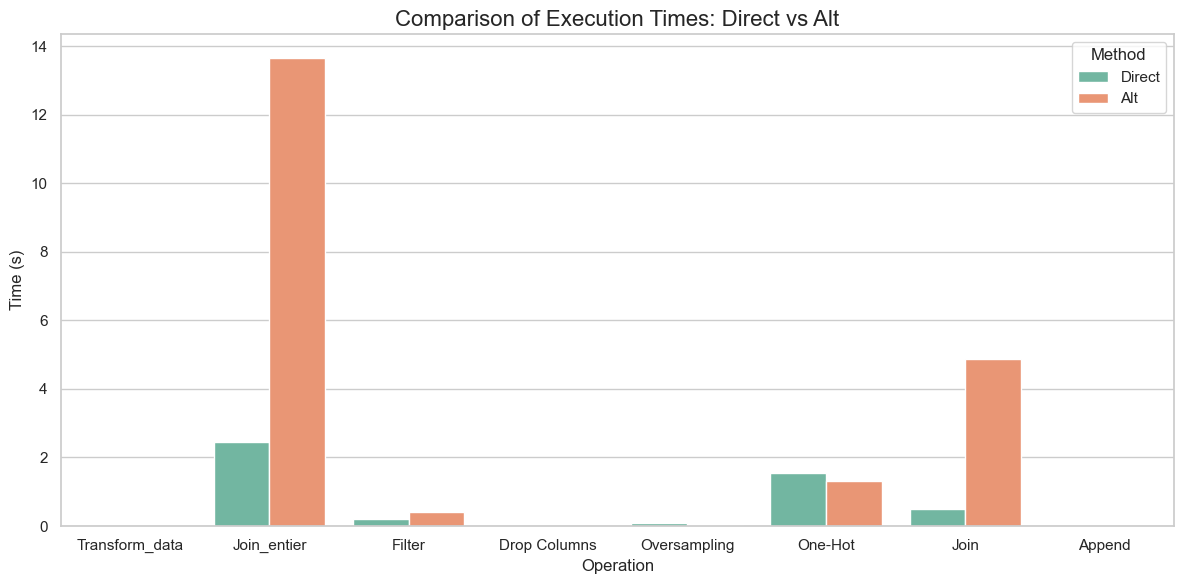

In [341]:
# 1. Graphique de comparaison du temps d'exécution (Time) pour chaque opération et méthode

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.barplot(x='Operation', y='Time (s)', hue='Method', data=performance_df, palette='Set2')
plt.title('Comparison of Execution Times: Direct vs Alt', fontsize=16)
plt.ylabel('Time (s)', fontsize=12)
plt.xlabel('Operation', fontsize=12)
plt.legend(title='Method')
plt.tight_layout()

plt.savefig("performance_graph.png")
plt.show()

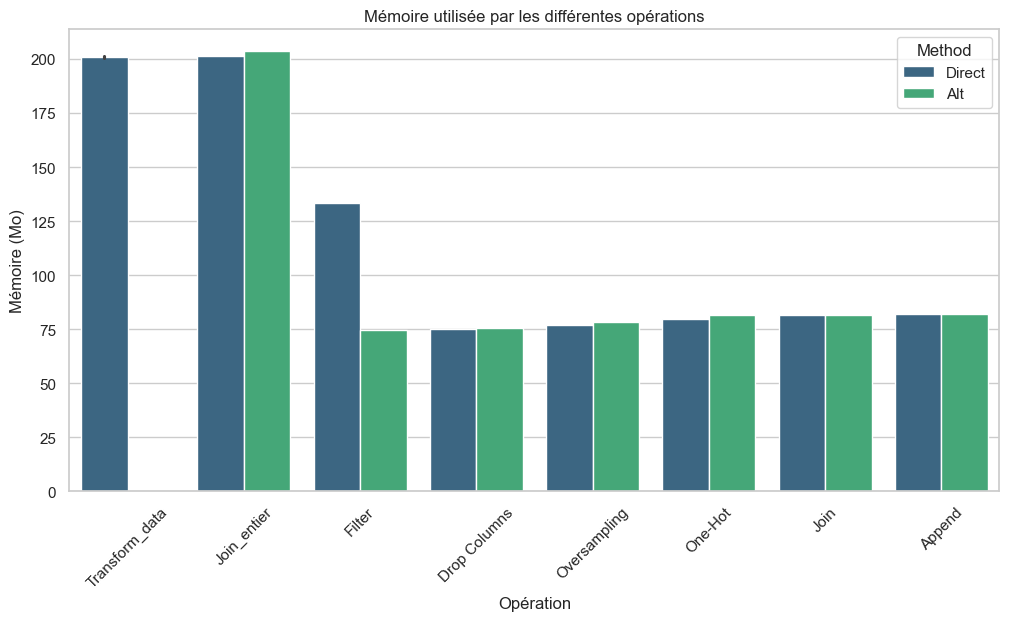

In [342]:
# 2. Graphique de la mémoire utilisée pour chaque opération et méthode
plt.figure(figsize=(12, 6))
sns.barplot(x='Operation', y='Memoire', hue='Method', data=performance_df,palette='viridis')
plt.title("Mémoire utilisée par les différentes opérations")
plt.ylabel("Mémoire (Mo)")
plt.xlabel("Opération")
plt.xticks(rotation=45)
plt.show()

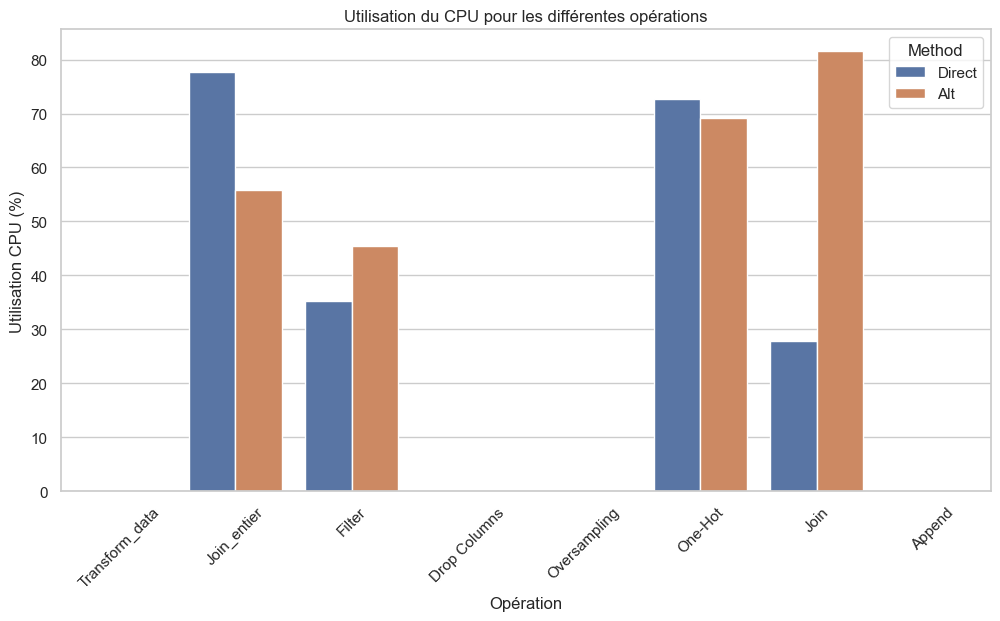

In [343]:
# 3. Graphique de l'utilisation du CPU pour chaque opération et méthode
plt.figure(figsize=(12, 6))
sns.barplot(x='Operation', y='CPU', hue='Method', data=performance_df)
plt.title("Utilisation du CPU pour les différentes opérations")
plt.ylabel("Utilisation CPU (%)")
plt.xlabel("Opération")
plt.xticks(rotation=45)
plt.show()